# Monster Recognition

The project aims to develop a classifier for Monster Energy drinks by focusing on finding the best
techniques for constructing an accurate bounding box around the can in the image and then classify them.

In [2]:
import os
# PATHS 
# Change root_path and repo_path to the correct ones
root_path = "/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject"
repo_path = "/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/MonsterRecognition"

train_dir = os.path.join(root_path, "Monster_energy_drink/train")
test_dir = os.path.join(root_path, "Monster_energy_drink/test")
output_train_dir = os.path.join(root_path, "DatasetInference/train")
output_test_dir = os.path.join(root_path, "DatasetInference/test")

output_results = os.path.join(repo_path, "Results")
model_statistics_path = os.path.join(repo_path, "ModelResults/model_statistics.txt")
model_path = os.path.join(repo_path, "ModelResults/trained_model.joblib")
encoder_path = os.path.join(repo_path, "ModelResults/label_encoder.pkl")

images_folder = os.path.join(repo_path, "Images")
output_folder = repo_path
cropped_folder = os.path.join(output_folder, "ImageCropped") 

## Dataset
The dataset is composed by images taken from Kaggle and images images made by us.

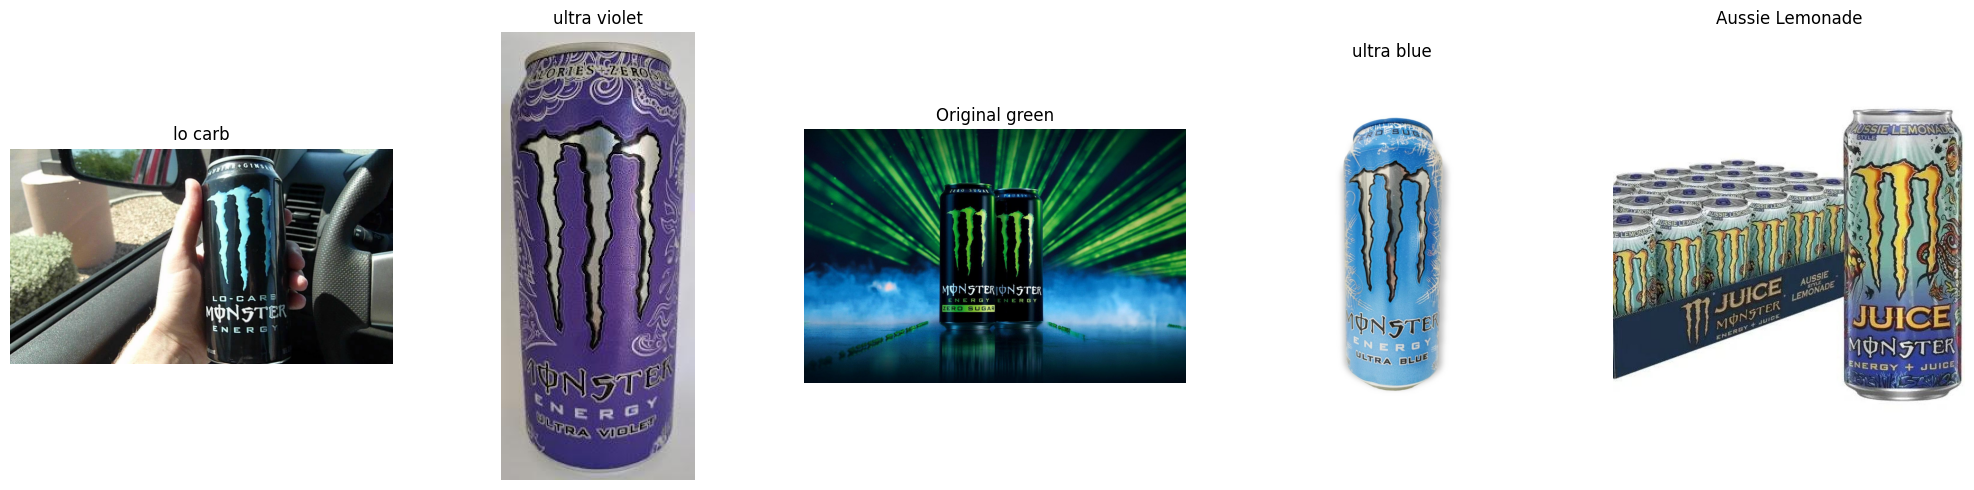

In [ ]:
import random
from PIL import Image

import matplotlib.pyplot as plt

labels = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

selected_images = []
for label in labels:
    label_dir = os.path.join(test_dir, label)
    images = [f for f in os.listdir(label_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
    if images:
        selected_images.extend([(os.path.join(label_dir, img), label) for img in random.sample(images, min(5, len(images)))])

selected_images = random.sample(selected_images, 5)

# visualize the selected images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, (img_path, label) in zip(axes, selected_images):
    image = Image.open(img_path)
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')  

plt.tight_layout()
plt.show()

## Metodology
The methodology of this project integrates several stages of template matching and find bounding
boxes, image processing, feature extraction, object detection, and machine learning classification to
achieve accurate recognition of Monster Energy cans.

### Template Matching
One image from the training dataset was taken and settted as a template to find match regions in other
images. It is so that Monster Energy cans are be easily distinguished. The function matchTemplate
provided by OpenCV was used to compare the template to regions of the scene. The function normally
returns a score of similarity as a result of comparing a few different methods among each region in
the scene about the template.

However, the bounding boxes drawn are decent only
in simpler scenarios, such as detecting a single can, but they become really poor when the scenario
becomes more complex, such as the case where multiple cans appear in the same image, or where
other subjects-such as a person-or complicate backgrounds are present. In such cases, the accuracy
and precision of the bounding box placement are significantly reduced.


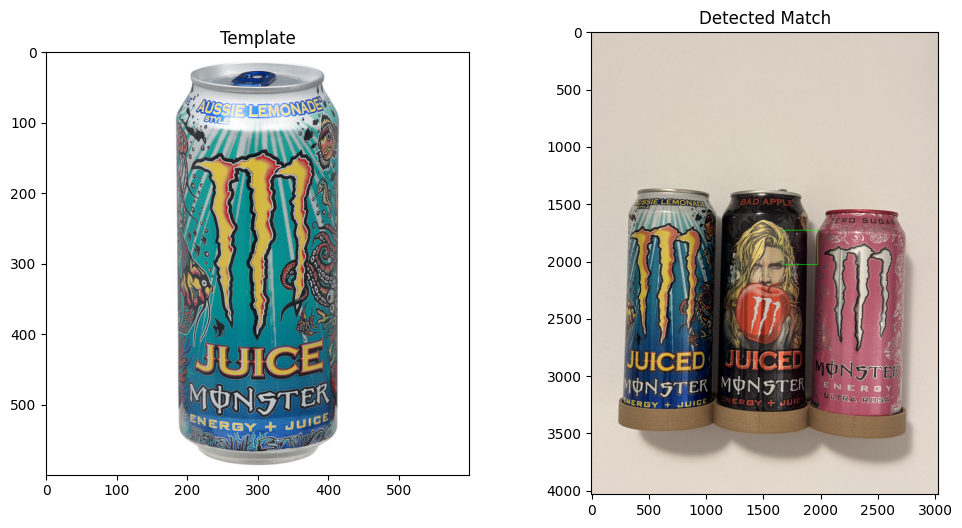

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the template and scene images
template_path = "/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/Monster_energy_drink/train/Aussie Lemonade/Imagem_1.png"
scene_path = "/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/MonsterRecognition/Images/tris4.JPG"

template = cv2.imread(template_path, cv2.IMREAD_COLOR)
scene = cv2.imread(scene_path, cv2.IMREAD_COLOR)

# Convert images to grayscale
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)

# Get template dimensions
h, w = template_gray.shape

# Initialize variables to store the best match
best_match = None
best_val = -np.inf
best_bbox = None

# Define scales and rotations to search
scales = np.linspace(0.5, 1.5, 20)  # From 50% to 150% of the original size
angles = np.arange(0, 360, 10)      # Every 30 degrees

# Perform template matching with scaling and rotation
for scale in scales:
    for angle in angles:
        # Resize template based on scale
        scaled_template = cv2.resize(template_gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        sh, sw = scaled_template.shape

        # Rotate the scaled template
        center = (sw // 2, sh // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_template = cv2.warpAffine(scaled_template, rotation_matrix, (sw, sh), flags=cv2.INTER_LINEAR)

        # Match the template to the scene
        result = cv2.matchTemplate(scene_gray, rotated_template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Update the best match if necessary
        if max_val > best_val:
            best_val = max_val
            best_match = rotated_template
            best_bbox = (max_loc[0], max_loc[1], max_loc[0] + sw, max_loc[1] + sh)

# Draw the best match on the scene image
if best_bbox:
    x1, y1, x2, y2 = best_bbox
    cv2.rectangle(scene, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
plt.title("Detected Match")

plt.show()

### Bounding Box

The detection of bounding boxes around Monster Energy cans is a critical step in the recognition
pipeline, ensuring that only the relevant portions of the images are processed for classification. 
This task is handled by a Roboflow API to perform object detection with high accuracy.
The script utilizes the Roboflow Inference API, a cloud-based service for object detection, to iden-
tify and localize Monster Energy cans within the images. The specific model used for detection is
identified as ```tin-can-r0yev/1```, which is trained to recognize the shapes and characteristics of cans.

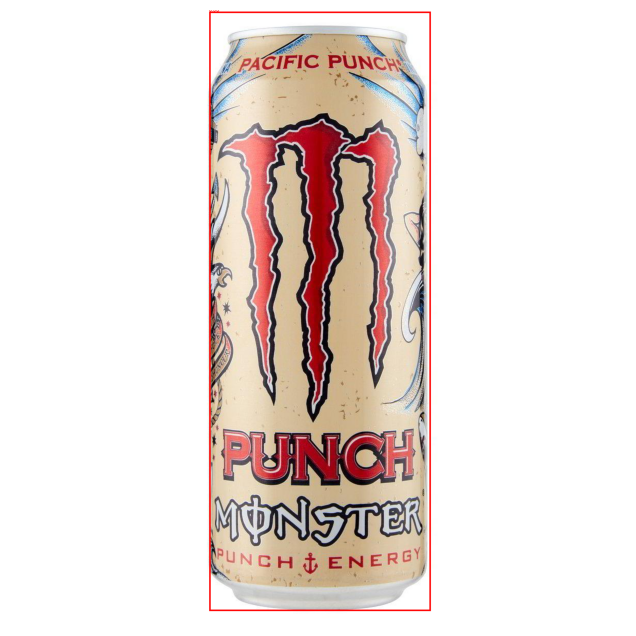

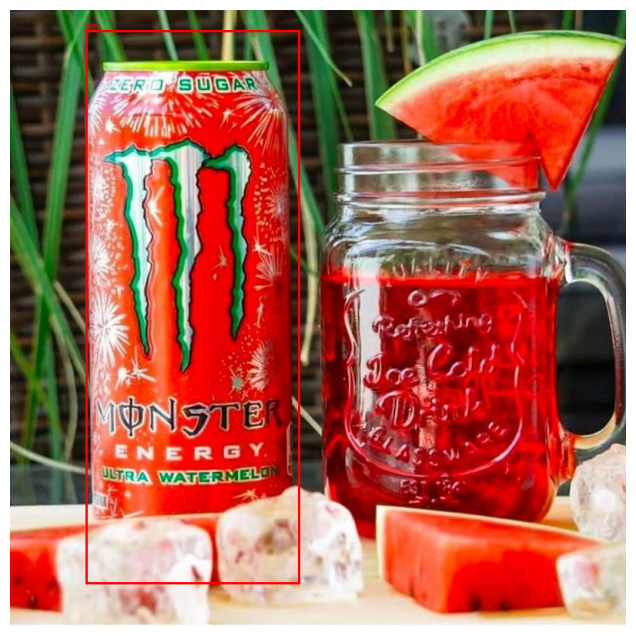

In [5]:
import os
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from PIL import Image, ImageDraw, ImageOps

def run_inference_and_display(in_path):
    """
    Runs inference on an input image, draws bounding boxes around detected objects,
    and displays the output image in a Jupyter Notebook.
    Args:
        in_path (str): The file path to the input image.
    Returns:
        None
    """
    CLIENT = InferenceHTTPClient(
        api_url="https://detect.roboflow.com",
        api_key="2YoFjYTilm3H760rS15g"
    )
    result = CLIENT.infer(in_path, model_id="tin-can-r0yev/1")

    original_image = Image.open(in_path).convert("RGB")
    image_width = result['image']['width']
    image_height = result['image']['height']

    if not result['predictions']:
        print(f"No predictions found for {in_path}!") 
        return
    
    draw = ImageDraw.Draw(original_image) # Draw bounding box on image
    for prediction in result['predictions']:
        x = prediction['x']
        y = prediction['y']
        width = prediction['width']
        height = prediction['height']

        left = max(0, x - width / 2)
        top = max(0, y - height / 2)
        right = min(image_width, x + width / 2)
        bottom = min(image_height, y + height / 2)

        draw.rectangle([left, top, right, bottom], outline="red", width=3)

        confidence = prediction.get('confidence', 0)
        draw.text((left, top - 10), f"{confidence:.2f}", fill="red")

    # Display the processed image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.axis("off")
    plt.show()

run_inference_and_display("/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/Monster_energy_drink/train/Pacific Punch/Imagem_12.jpg")
run_inference_and_display("/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/Monster_energy_drink/train/ultra watermelon/Imagem_56.jpg")


### Pre-Process 
After the extraction of bounding boxes, the new dataset is made only by images showing cans only.
The next step involves preprocessing the images to improve model generalization and robustness.
In creating the training dataset, a pre-prossessing pipeline used a sequence of random transforma-
tions on every image so as to improve the dataset generalization. 

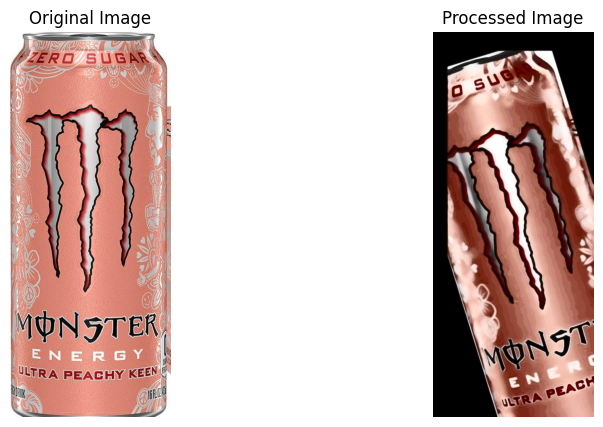

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def apply_random_transformations(image):
    """
    Apply a series of random transformations to an input image.
    """
    if random.random() > 0.5:
        image = cv2.flip(image, 1) # Horizontal Flipping: Randomly flips images horizontally to introduce variations in orientation.

    # Rotation and Scaling: Applies random rotations (between -30° and 30°) and zooms (scaling between 0.8 and 1.2) to simulate different perspectives.
    angle = random.uniform(-30, 30)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    scale = random.uniform(0.8, 1.2)
    zoomed = cv2.resize(rotated, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    # Translation: Shifts the images up to 10% of their dimensions to vary object positioning.
    tx = random.uniform(-0.1, 0.1) * zoomed.shape[1]
    ty = random.uniform(-0.1, 0.1) * zoomed.shape[0]
    M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(zoomed, M_translation, (zoomed.shape[1], zoomed.shape[0]))

    # Brightness and Contrast: Randomly adjusts the brightness and contrast of the images.
    alpha = random.uniform(0.7, 1.3)
    beta = random.uniform(-50, 50)
    adjusted = cv2.convertScaleAbs(translated, alpha=alpha, beta=beta)

    # Gaussian Blurring: Applies Gaussian blurring with a random kernel size to smooth the images.
    ksize = random.choice([(3, 3), (5, 5), (7, 7)])
    filtered = cv2.GaussianBlur(adjusted, ksize, 0)

    # Denoising: Applies non-local means denoising to remove noise from the images.
    denoised = cv2.fastNlMeansDenoisingColored(filtered, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

    # Histogram Equalization: Enhances the contrast of the images using histogram equalization.
    img_yuv = cv2.cvtColor(denoised, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    normalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    return normalized

def preprocess_single_image(image_path):
    """
    Preprocess a single image and display the result.
    """
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return
    
    processed_image = apply_random_transformations(image)
    
    # Convert BGR to RGB for correct visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    
    # Display original and processed images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image_rgb)
    plt.title("Processed Image")
    plt.axis("off")
    
    plt.show()
    
# Example usage:
preprocess_single_image("/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/DatasetInference/train/ultra peachy keen/Imagem_1_crop1.png")


### Color Classification
The classification of Monster Energy cans based on color is a multi-step process that involves the
extraction of detailed color and texture features from images, followed by the application of a machine
learning model for classification.

### Features Extraction 
The first step in color-based classification involves extracting relevant features from the images, which
are used to represent the unique color characteristics of each can.

**Histograms**
* **RGB**: The script computes histograms for each of the Red, Green, and Blue channels,
capturing the distribution of primary colors within the image. Each channel is divided into 32
bins, resulting in 96 features (32 bins × 3 channels).
* **HSV**: To capture more nuanced color information, the images are also converted
to the HSV (Hue, Saturation, Value) color space. Histograms are computed for each channel,
providing an additional 96 features that account for variations in hue and intensity, which are
crucial for distinguishing cans with similar RGB compositions but different tones or brightness
levels
* **GLCM**:  Beyond color, the script extracts texture features using the Gray Level
Co-occurrence Matrix (GLCM). Five key texture properties: contrast, dissimilarity, homogeneity, energy, and correlation—are calculated from the grayscale version of the image. These
features help in differentiating cans not only by color but also by the unique textural patterns
on their surfaces

In [7]:
import pandas as pd

# Display the first few rows of the train histogram csv
train_hist_path = os.path.join(output_results, 'train_histograms_features.csv')
train_histograms = pd.read_csv(train_hist_path)
print("Example of Train histogram: \n")
train_histograms=pd.DataFrame(train_histograms)
train_histograms

Example of Train histogram: 



,Bin_R1,Bin_R2,Bin_R3,Bin_R4,Bin_R5,Bin_R6,Bin_R7,Bin_R8,Bin_R9,Bin_R10,...,Bin_V29,Bin_V30,Bin_V31,Bin_V32,GLCM_Contrast,GLCM_Dissimilarity,GLCM_Homogeneity,GLCM_Energy,GLCM_Correlation,Label
0,635.0,623.0,665.0,592.0,465.0,437.0,510.0,535.0,484.0,549.0,...,303.0,265.0,229.0,1765.0,521.660157,11.700244,0.403678,0.132980,0.952383,ultra red
1,235.0,350.0,414.0,440.0,594.0,906.0,1577.0,2427.0,3658.0,5288.0,...,5634.0,7121.0,8375.0,17560.0,901.549020,18.996111,0.127838,0.031422,0.876089,ultra red
2,327.0,605.0,2524.0,5664.0,5199.0,6471.0,24989.0,12377.0,7366.0,6114.0,...,751.0,461.0,466.0,570.0,145.742771,5.857291,0.400910,0.088187,0.921987,ultra red
3,9266.0,2034.0,1419.0,1251.0,959.0,968.0,1068.0,1261.0,1200.0,1137.0,...,3524.0,3943.0,4431.0,11809.0,376.260199,8.856883,0.341741,0.045610,0.963515,ultra red
4,15657.0,12144.0,7134.0,7332.0,7862.0,6812.0,5278.0,3989.0,2854.0,2002.0,...,1685.0,1286.0,1124.0,1789.0,247.045409,7.906728,0.283957,0.024231,0.945982,ultra red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6905,428119.0,24424.0,30723.0,18149.0,39624.0,27004.0,25443.0,27874.0,32320.0,31311.0,...,36305.0,138.0,69121.0,48764.0,15.452557,0.865014,0.868820,0.306453,0.998967,MIXXD
6906,53291.0,57694.0,54807.0,59277.0,54705.0,51643.0,65888.0,52513.0,82213.0,51557.0,...,4375.0,468271.0,24149.0,117950.0,101.560569,3.025515,0.784042,0.267384,0.991844,MIXXD
6907,109631.0,41653.0,209167.0,607959.0,371221.0,279129.0,224212.0,192993.0,170200.0,138694.0,...,27244.0,15436.0,14602.0,35194.0,17.318629,1.762035,0.579382,0.047608,0.996172,MIXXD
6908,145536.0,72354.0,157820.0,320563.0,373477.0,185634.0,106640.0,106207.0,115772.0,97504.0,...,52752.0,36724.0,7921.0,9849.0,20.956089,2.115192,0.538034,0.047264,0.995850,MIXXD


**Classification**  
Once the features are extracted, they are used to train a classification model. The classification process
follows these steps:
1. Data Standardization: The extracted features are standardized using StandardScaler to ensure
consistent scaling across all features, which is critical for the effective training of neural networks.
2. Label Encoding: Can labels, representing different Monster Energy flavors or types, are encoded
into numerical values using LabelEncoder, preparing them for the machine learning model.
3. Model Training: The core of the classification is handled by a Multi-layer Perceptron (MLP)
classifier. The MLP is configured with two hidden layers, each containing 50 neurons, and uses
the ReLU activation function for non-linearity. The model is trained with an adaptive learning
rate and early stopping to prevent overfitting. The training process adjusts the model weights
to minimize classification errors based on the color and texture features.
4. Classification: After training, the model is used to classify new images based on their color
features. The predictions are decoded back to their original labels using the LabelEncoder, and
confidence scores are provided for each classification.
5. Evaluation: The model’s performance is evaluated using accuracy metrics and classification
reports, providing insight into how well the color features distinguish between different can
types. The evaluation results are saved for further analysis.


In [ ]:
from joblib import load
import pickle
model = load(model_path)
with open(encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)
print("Model and encoder loaded")

Model and encoder loaded


In [ ]:
# Visualize model metrics
with open(model_statistics_path, 'r') as file:
    model_statistics = file.read()

print("Model Statistics:\n", model_statistics)



Model Statistics:
 Accuracy: 85.85%

Classification Report:
                         precision    recall  f1-score   support

                Assault       1.00      1.00      1.00        13
        Aussie Lemonade       0.71      0.95      0.81        55
               Espresso       1.00      1.00      1.00        13
                 Import       0.95      0.95      0.95        37
       Java Triple Shot       0.98      1.00      0.99        55
                Khaotic       0.94      1.00      0.97        50
         Lewis Hamilton       1.00      1.00      1.00        17
                  MIXXD       1.00      0.97      0.98        32
                   MULE       0.99      1.00      0.99        84
             Mango Loco       0.75      0.69      0.72        48
                Monarch       1.00      0.98      0.99        53
      Orange Dreamsicle       1.00      1.00      1.00        94
         Original green       0.74      0.61      0.67        41
          Pacific Punch      

### Text Recognition

The images are taken to the preprocessing stage where the images are converted to grayscale and binarization is applied so that the text is clearer and the contrast is higher.
Moreover, the use of a sizing step help to ensure that small and barely visible text gets more readable.
Then, OCR was applied to targeted region of interest, where textual information appears. Filtration
allowed the removal of text with low confidence scores or disproportionately large bounding boxes
to minimize errors. 

Different filters were tried to remove noise and improve readability, such as Gaussian Blur,
Laplacian and Median filtering. 

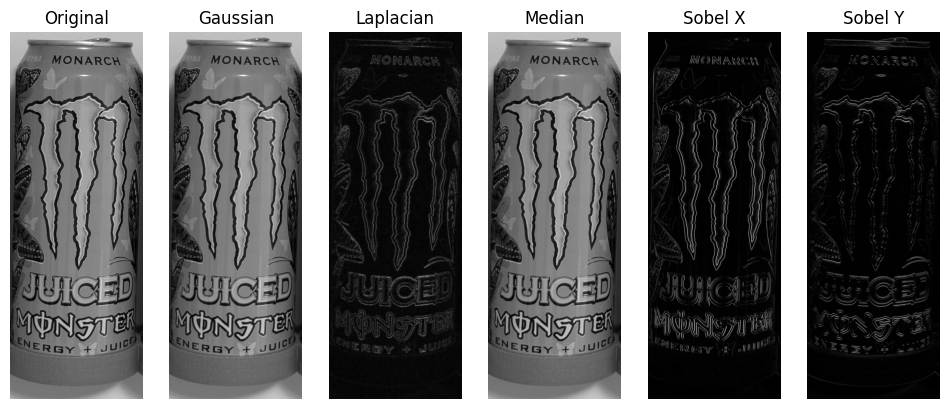

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def median_filter(data, filter_size):
    indexer = filter_size // 2
    data_padded = np.pad(data, indexer, mode='edge')  
    data_final = np.zeros_like(data)
    
    for i in range(len(data)):
        for j in range(len(data[0])):
            # Estrazione della finestra locale
            window = data_padded[i:i+filter_size, j:j+filter_size].flatten()
            data_final[i, j] = np.median(window)  
            
    return data_final

def apply_filters(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    filtered_gaussian = cv2.GaussianBlur(image, (5, 5), 0)
    filtered_laplacian = cv2.Laplacian(image, cv2.CV_64F)
    filtered_median = median_filter(image, 5)
    filtered_sobel_x = cv2.Sobel(filtered_median, cv2.CV_64F, 1, 0, ksize=5)
    filtered_sobel_y = cv2.Sobel(filtered_median, cv2.CV_64F, 0, 1, ksize=5)
    
    images = [image, filtered_gaussian, np.abs(filtered_laplacian), filtered_median, np.abs(filtered_sobel_x), np.abs(filtered_sobel_y)]
    titles = ["Original", "Gaussian", "Laplacian", "Median", "Sobel X", "Sobel Y"]
    
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


apply_filters("/MonsterRecognition/ImageCropped/tris2_crop1.png")


Post-processing further refined results by matching OCR outputs against a predefined vocabulary of Monster Energy flavor names, correcting inaccuracies through string-matching
techniques.

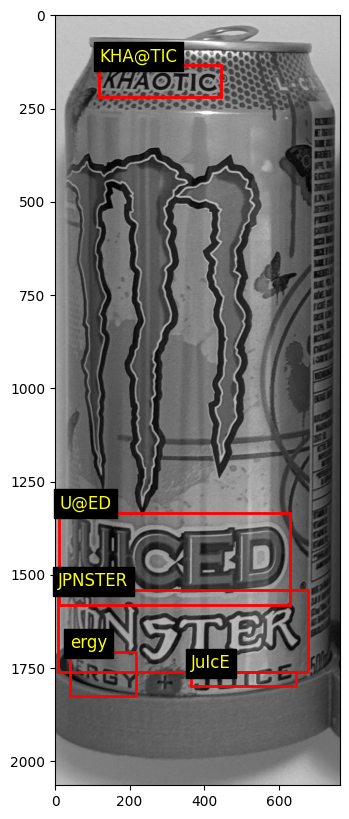

Recognized Text: ['KHA@TIC', 'U@ED', 'JPNSTER', 'ergy', 'JuIcE']


In [9]:
import cv2
from rapidfuzz import process
import matplotlib.pyplot as plt
import easyocr
import numpy as np
import pandas as pd

def text_recognition(image):
    reader = easyocr.Reader(['en', 'it', 'es'], gpu=False, verbose=False)
    text_results = reader.readtext(image)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    for bbox, text, score in text_results:
        if score > 0.10 and len(text) > 3:
            top_left = tuple(map(int, bbox[0]))
            bottom_right = tuple(map(int, bbox[2]))
            plt.gca().add_patch(plt.Rectangle(top_left, bottom_right[0] - top_left[0], bottom_right[1] - top_left[1], edgecolor='red', linewidth=2, fill=False))
            plt.text(top_left[0], top_left[1] - 10, text, color='yellow', fontsize=12, backgroundcolor='black')
    plt.show()
    
    return [text for _, text, score in text_results if score > 0.10]

# Example of usage:
image_path = "/Users/martinapanini/Library/Mobile Documents/com~apple~CloudDocs/Università/I Semestre/Signal_Image_Video/MonsterProject/MonsterRecognition/ImageCropped/tris2_crop0.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
recognized_texts = text_recognition(image)
print("Recognized Text:", recognized_texts)


## Results
Compare results with the ones obtained with text recognition.

In [ ]:
# Define the path to the classification results file
classification_results_path = os.path.join(output_results, 'classification_results.txt')

# Load the classification results
with open(classification_results_path, 'r') as file:
    classification_results = file.read()

# Print the classification results
print("Classification Results:\n", classification_results)

Classification Results:
 
COLOR AND TEXT CLASSIFICATION RESULTS:
             Image      TextFilter        Text TextAccuracy Color Prediction  Color Accuracy
0  tris2_crop0.png  Original Image     KHAOTIC    77.142857          Khaotic           98.25
1  tris2_crop1.png  Original Image     MONARCH         90.0          Monarch           89.46
2  tris2_crop2.png  Original Image  MANGO LOCO         90.0       Mango Loco           98.31

MONSTER THAT YOU HAVE:
Khaotic
MONARCH
Mango Loco

MISSING MONSTER ARE:
nitro super dry, Zero Sugar, Lewis Hamilton, Ultra Citron, Java Triple Shot, tea lemonade, Aussie Lemonade, Ultra Fantasy Ruby Red, Pipeline Punch, ultra gold, Import, Pacific Punch, lo carb, ultra violet, ultra watermelon, nitro cosmic peach, MIXXD, MULE, ultra peachy keen, Original green, Ultra Paradise, Orange Dreamsicle, java salted caramel, Ultra Fiesta Mango, Assault, Ultra, Super Fuel, Rehab Peach Tea, Espresso, ultra blue, ultra red, ultra rosa, ultra sunrise, ultra strawberry 